## Geo3D Spectral Coherence between Gravity and Bathymetry Grids

The PyGMTSAR InSAR library, Geomed3D Geophysical Inversion Library, N-Cube 3D/4D GIS Data Visualization, among others, are my open-source projects developed in my free time. I hold a Master's degree in STEM, specializing in radio physics. In 2004, I received the first prize in the All-Russian Physics Competition for significant results in forward and inverse modeling for nonlinear optics and holography. These skills are also applicable to modeling Gravity, Magnetic, and Thermal fields, as well as satellite interferometry processing. With 20 years of experience as a data scientist and software developer, I have contributed to scientific and industrial development, working on government contracts, university projects, and with companies like LG Corp and Google Inc.

You can support my work on [Patreon](https://www.patreon.com/pechnikov), where I share updates on my projects, publications, use cases, examples, and other useful information. For research and development services and support, please visit my profile on the freelance platform [Upwork](https://www.upwork.com).

### Resources
- Google Colab Pro notebooks and articles on [Patreon](https://www.patreon.com/pechnikov),
- Google Colab notebooks on [GitHub](https://github.com),
- Docker Images on [DockerHub](https://hub.docker.com),
- Geological Models on [YouTube](https://www.youtube.com),
- VR/AR Geological Models on [GitHub](https://github.com),
- Live updates and announcements on [LinkedIn](https://www.linkedin.com/in/alexey-pechnikov/).

© Alexey Pechnikov, 2024

## Google Colab Installation

In [1]:
import sys
if 'google.colab' in sys.modules:
    !apt-get update > /dev/null && apt install gdal-bin > /dev/null
    !{sys.executable} -m pip install -q matplotlib >/dev/null
    !{sys.executable} -m pip install -q git+https://github.com/AlexeyPechnikov/geo3d.git >/dev/null

## Load and Setup Python Modules

In [2]:
import rioxarray as rio
import numpy as np
import geo3d

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import patheffects
%matplotlib inline

## Download and Prepare Datasets

In [3]:
# create data and output directories
!mkdir -p ../data/raw ../data/processed

In [4]:
# https://www.gebco.net/data_and_products/gridded_bathymetry_data/gebco_2023/
!cd ../data/raw && wget -O gebco_2023.zip -c https://www.bodc.ac.uk/data/open_download/gebco/gebco_2023/zip/
!cd ../data/raw && unzip -n gebco_2023.zip GEBCO_2023.nc
# reproject and crop area
!cd ../data/raw && rm -f GEBCO.subset.32702.tif && \
    gdalwarp -s_srs WGS84 -t_srs EPSG:32702 -te 444000 3170000 614000 3348000 -tr 500 500 -r bilinear \
        GEBCO_2023.nc GEBCO.subset.32702.tif

--2024-02-12 14:01:07--  https://www.bodc.ac.uk/data/open_download/gebco/gebco_2023/zip/
Resolving www.bodc.ac.uk (www.bodc.ac.uk)... 192.171.196.106
Connecting to www.bodc.ac.uk (www.bodc.ac.uk)|192.171.196.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4227146427 (3.9G) [application/zip]
Saving to: ‘gebco_2023.zip’

gebco_2023.zip      100%[===================>]   3.94G  18.5MB/s    in 4m 49s  

2024-02-12 14:05:57 (13.9 MB/s) - ‘gebco_2023.zip’ saved [4227146427/4227146427]

Archive:  gebco_2023.zip
  inflating: GEBCO_2023.nc           
Creating output file that is 340P x 356L.
Processing GEBCO_2023.nc [1/1] : 0Using internal nodata values (e.g. -32767) for image GEBCO_2023.nc.
Copying nodata values from source GEBCO_2023.nc to destination GEBCO.subset.32702.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


In [5]:
# https://topex.ucsd.edu/marine_grav/mar_grav.html
!cd ../data/raw && wget -c https://topex.ucsd.edu/pub/global_grav_1min/grav_32.1.nc
# reproject and crop area from local Sandwell and Smith Gravity Anomaly dataset
!cd ../data/raw && rm -f grav.subset.32702.tif && \
    gdalwarp -s_srs WGS84 -t_srs EPSG:32702 -te 444000 3170000 614000 3348000 -tr 500 500 -r bilinear \
        grav_32.1.nc grav.subset.32702.tif

--2024-02-12 14:07:49--  https://topex.ucsd.edu/pub/global_grav_1min/grav_32.1.nc
Resolving topex.ucsd.edu (topex.ucsd.edu)... 132.239.154.64
Connecting to topex.ucsd.edu (topex.ucsd.edu)|132.239.154.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 629760718 (601M) [application/x-netcdf]
Saving to: ‘grav_32.1.nc’

grav_32.1.nc        100%[===================>] 600.59M  16.6MB/s    in 28s     

2024-02-12 14:08:17 (21.7 MB/s) - ‘grav_32.1.nc’ saved [629760718/629760718]

Creating output file that is 340P x 356L.
Processing grav_32.1.nc [1/1] : 0Using internal nodata values (e.g. nan) for image grav_32.1.nc.
Copying nodata values from source grav_32.1.nc to destination grav.subset.32702.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


In [6]:
# download Global Multi-Resolution Topography Data Synthesis
!cd ../data/raw && wget -c -O data.topo-mask.hires.tif \
    "https://www.gmrt.org/services/GridServer?north=-60&west=-172.5&east=-167.5&south=-62&layer=topo-mask&format=geotiff&resolution=high"
# reproject and crop area
!cd ../data/raw && rm -f data.topo-mask.hires.32702.tif && \
    gdalwarp -s_srs WGS84 -t_srs EPSG:32702 -te 444000 3170000 614000 3348000 -tr 500 500 -r bilinear \
        data.topo-mask.hires.tif data.topo-mask.hires.32702.tif

--2024-02-12 14:08:17--  https://www.gmrt.org/services/GridServer?north=-60&west=-172.5&east=-167.5&south=-62&layer=topo-mask&format=geotiff&resolution=high
Resolving www.gmrt.org (www.gmrt.org)... 44.206.144.100, 52.23.78.129, 35.168.215.36
Connecting to www.gmrt.org (www.gmrt.org)|44.206.144.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘data.topo-mask.hires.tif’

data.topo-mask.hire     [ <=>                ]  16.35M  --.-KB/s    in 0.06s   

2024-02-12 14:08:20 (258 MB/s) - ‘data.topo-mask.hires.tif’ saved [17149026]

Creating output file that is 340P x 356L.
Processing data.topo-mask.hires.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


In [7]:
# download WGM2012 Free-Air gravity
# https://bgi.obs-mip.fr/data-products/grids-and-models/wgm2012-global-model/
!cd ../data/raw && wget -c https://cdn.obs-mip.fr/bgi/wgm_grid/data/WGM2012_Freeair_ponc_2min.grd
# reproject and crop area
!cd ../data/raw && rm -f WGM2012_Freeair.subset.32702.tif && \
    gdalwarp -s_srs WGS84 -t_srs EPSG:32702 -te 444000 3170000 614000 3348000 -tr 500 500 -r bilinear \
    WGM2012_Freeair_ponc_2min.grd WGM2012_Freeair.subset.32702.tif

--2024-02-12 14:08:20--  https://cdn.obs-mip.fr/bgi/wgm_grid/data/WGM2012_Freeair_ponc_2min.grd
Resolving cdn.obs-mip.fr (cdn.obs-mip.fr)... 193.52.225.45
Connecting to cdn.obs-mip.fr (cdn.obs-mip.fr)|193.52.225.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 233410292 (223M) [application/vnd.gentics.grd+json]
Saving to: ‘WGM2012_Freeair_ponc_2min.grd’

WGM2012_Freeair_pon 100%[===================>] 222.60M  1.26MB/s    in 2m 32s  

2024-02-12 14:10:53 (1.47 MB/s) - ‘WGM2012_Freeair_ponc_2min.grd’ saved [233410292/233410292]

Creating output file that is 340P x 356L.
Processing WGM2012_Freeair_ponc_2min.grd [1/1] : 0Using internal nodata values (e.g. nan) for image WGM2012_Freeair_ponc_2min.grd.
Copying nodata values from source WGM2012_Freeair_ponc_2min.grd to destination WGM2012_Freeair.subset.32702.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


In [8]:
# fill NoData by interpolated values
!cd ../data/raw && gdal_fillnodata.py GEBCO.subset.32702.tif           GEBCO.subset.32702.fixed.tif
!cd ../data/raw && gdal_fillnodata.py grav.subset.32702.tif            grav.subset.32702.fixed.tif
!cd ../data/raw && gdal_fillnodata.py WGM2012_Freeair.subset.32702.tif WGM2012_Freeair.subset.32702.fixed.tif

0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


## Define parameters

In [9]:
# rasters below defined in projected coordinates system (EPSG:32702)
GEBCO   = '../data/raw/GEBCO.subset.32702.fixed.tif'
GMRT    = '../data/raw/data.topo-mask.hires.32702.tif'
GRAVITY = '../data/raw/grav.subset.32702.fixed.tif'
FREEAIR = '../data/raw/WGM2012_Freeair.subset.32702.fixed.tif'

# scale coefficient for rasters [km/pixel]
resolution = 0.5
# waveband in resolution units
SIGMA = 100
# waveband processing step
DSIGMA = 1

## Define discrete spectrum

In [10]:
sigmas = np.arange(DSIGMA, SIGMA+DSIGMA/2, DSIGMA)
sigmas

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100.])

## Load rasters

### GEBCO_2019 topography

In [11]:
dem = rio.open_rasterio(GEBCO).rename({'x':'lon','y':'lat'})
dem

<xarray.DataArray (band: 1, lat: 356, lon: 340)>
[121040 values with dtype=int16]
Coordinates:
  * band         (band) int64 1
  * lon          (lon) float64 4.442e+05 4.448e+05 ... 6.132e+05 6.138e+05
  * lat          (lat) float64 3.348e+06 3.347e+06 ... 3.171e+06 3.17e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -32767
    scale_factor:   1.0
    add_offset:     0.0

## Global Multi-Resolution Topography Data Synthesis

In [12]:
gmt = rio.open_rasterio(GMRT).rename({'x':'lon','y':'lat'})
# mark NoDATA values as NaN
gmt.values[gmt.values==0] = np.nan
gmt

<xarray.DataArray (band: 1, lat: 356, lon: 340)>
array([[[       nan, -4243.946 , ...,        nan,        nan],
        [       nan, -4284.5566, ...,        nan,        nan],
        ...,
        [       nan,        nan, ...,        nan,        nan],
        [       nan,        nan, ...,        nan,        nan]]], dtype=float32)
Coordinates:
  * band         (band) int64 1
  * lon          (lon) float64 4.442e+05 4.448e+05 ... 6.132e+05 6.138e+05
  * lat          (lat) float64 3.348e+06 3.347e+06 ... 3.171e+06 3.17e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

### WGM2012 Free-Air Gravity Anomalies

In [13]:
frr = rio.open_rasterio(FREEAIR).rename({'x':'lon','y':'lat'})
frr

<xarray.DataArray (band: 1, lat: 356, lon: 340)>
[121040 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * lon          (lon) float64 4.442e+05 4.448e+05 ... 6.132e+05 6.138e+05
  * lat          (lat) float64 3.348e+06 3.347e+06 ... 3.171e+06 3.17e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     nan
    scale_factor:   1.0
    add_offset:     0.0

### Sandwell and Smith Gravity Anomaly

In [14]:
grv = rio.open_rasterio(GRAVITY).rename({'x':'lon','y':'lat'})
grv

<xarray.DataArray (band: 1, lat: 356, lon: 340)>
[121040 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * lon          (lon) float64 4.442e+05 4.448e+05 ... 6.132e+05 6.138e+05
  * lat          (lat) float64 3.348e+06 3.347e+06 ... 3.171e+06 3.17e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     nan
    scale_factor:   1.0
    add_offset:     0.0

## Plot datasets

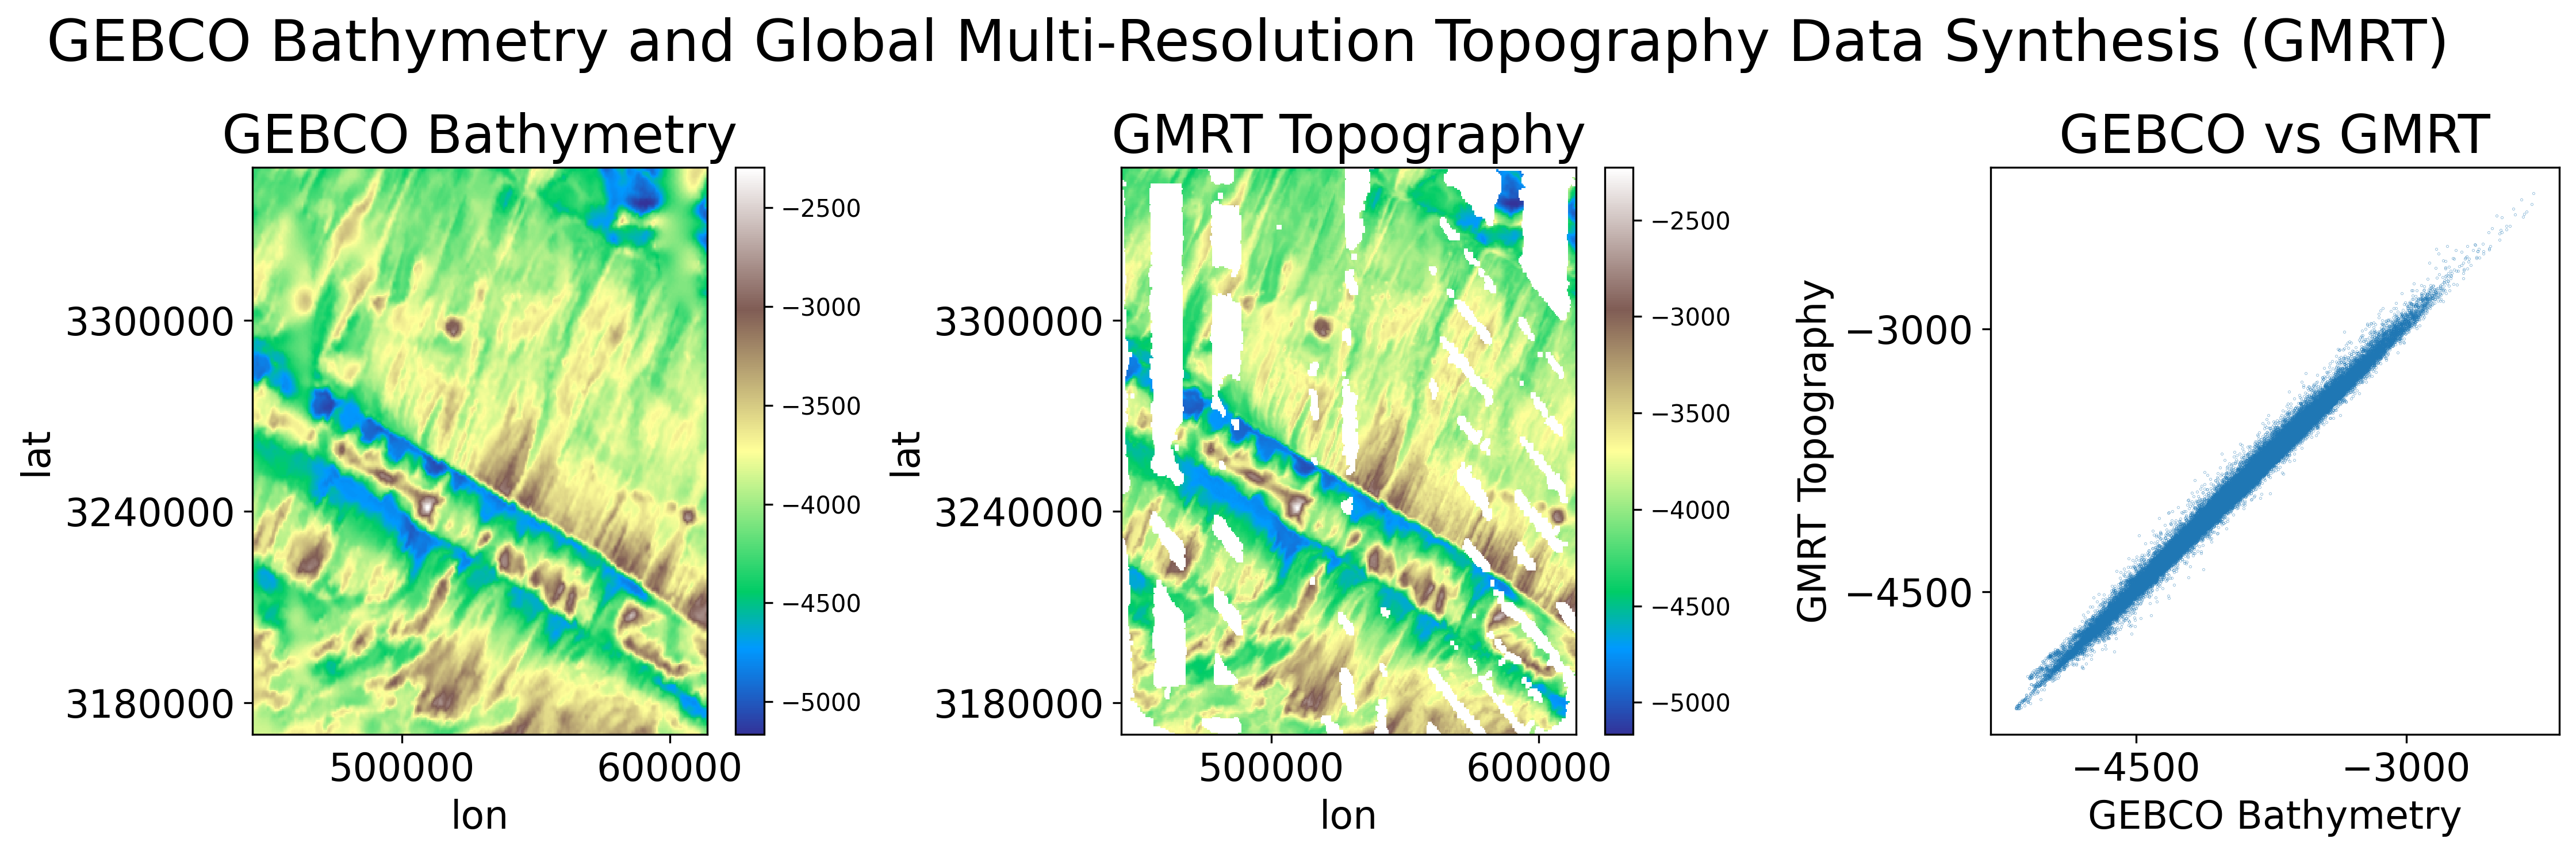

In [15]:
fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(15.5,5), dpi=300)

dem.plot(ax=ax1, cmap='terrain')
ax1.set_title('GEBCO Bathymetry')

gmt.plot(ax=ax2, cmap='terrain')
ax2.set_title('GMRT Topography')

ax3.scatter(dem.values, gmt.values, s=0.01)
ax3.set_title('GEBCO vs GMRT')
ax3.set_xlabel('GEBCO Bathymetry')
ax3.set_ylabel('GMRT Topography')

for ax in (ax1,ax2,ax3):
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=2))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
    ax.ticklabel_format(useOffset=False, style='plain', axis='y')
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.set_xlabel(ax.get_xlabel(), fontsize=16)
    ax.set_ylabel(ax.get_ylabel(), fontsize=16)
    ax.set_title(ax.get_title(), fontsize=22)

fig.tight_layout(rect=[0.03, 0.0, 1, 0.9])
plt.suptitle('GEBCO Bathymetry and Global Multi-Resolution Topography Data Synthesis (GMRT)',fontsize=24)
plt.savefig('../data/processed/GEBCO and Global Multi-Resolution Topography Data Synthesis (GMRT).jpg')
plt.show()

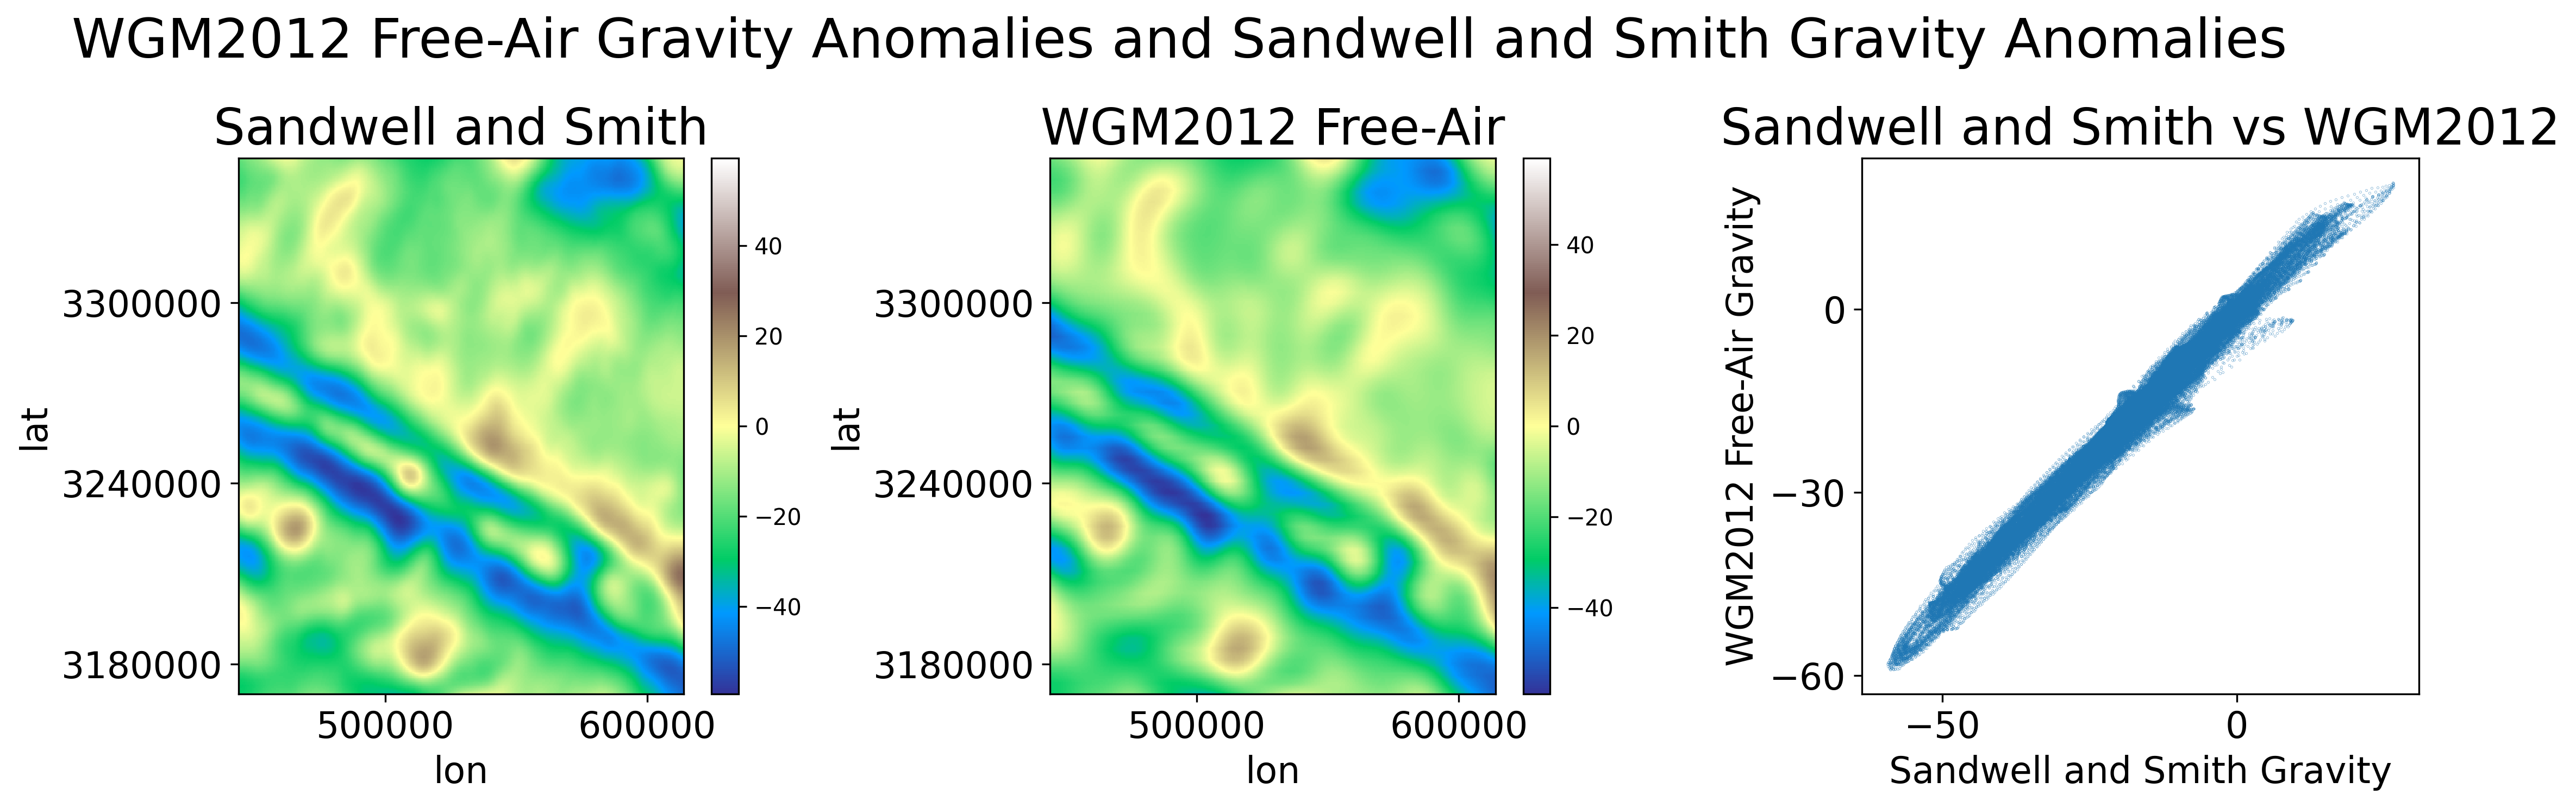

In [16]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15.5,5), dpi=300)

grv.plot(ax=ax1, cmap='terrain')
ax1.set_title('Sandwell and Smith')

frr.plot(ax=ax2, cmap='terrain')
ax2.set_title('WGM2012 Free-Air')

ax3.scatter(grv.values, frr.values, s=0.01)
ax3.set_title('Sandwell and Smith vs WGM2012')
ax3.set_xlabel('Sandwell and Smith Gravity')
ax3.set_ylabel('WGM2012 Free-Air Gravity')

for ax in (ax1,ax2,ax3):
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=2))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
    ax.ticklabel_format(useOffset=False, style='plain', axis='y')
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.set_xlabel(ax.get_xlabel(), fontsize=16)
    ax.set_ylabel(ax.get_ylabel(), fontsize=16)
    ax.set_title(ax.get_title(), fontsize=22)

fig.tight_layout(rect=[0.03, 0.0, 1, 0.9])
plt.suptitle('WGM2012 Free-Air Gravity Anomalies and Sandwell and Smith Gravity Anomalies', fontsize=24)
plt.savefig('../data/processed/WGM2012 Free-Air Gravity Anomalies and Sandwell and Smith Gravity Anomalies.jpg')
plt.show()

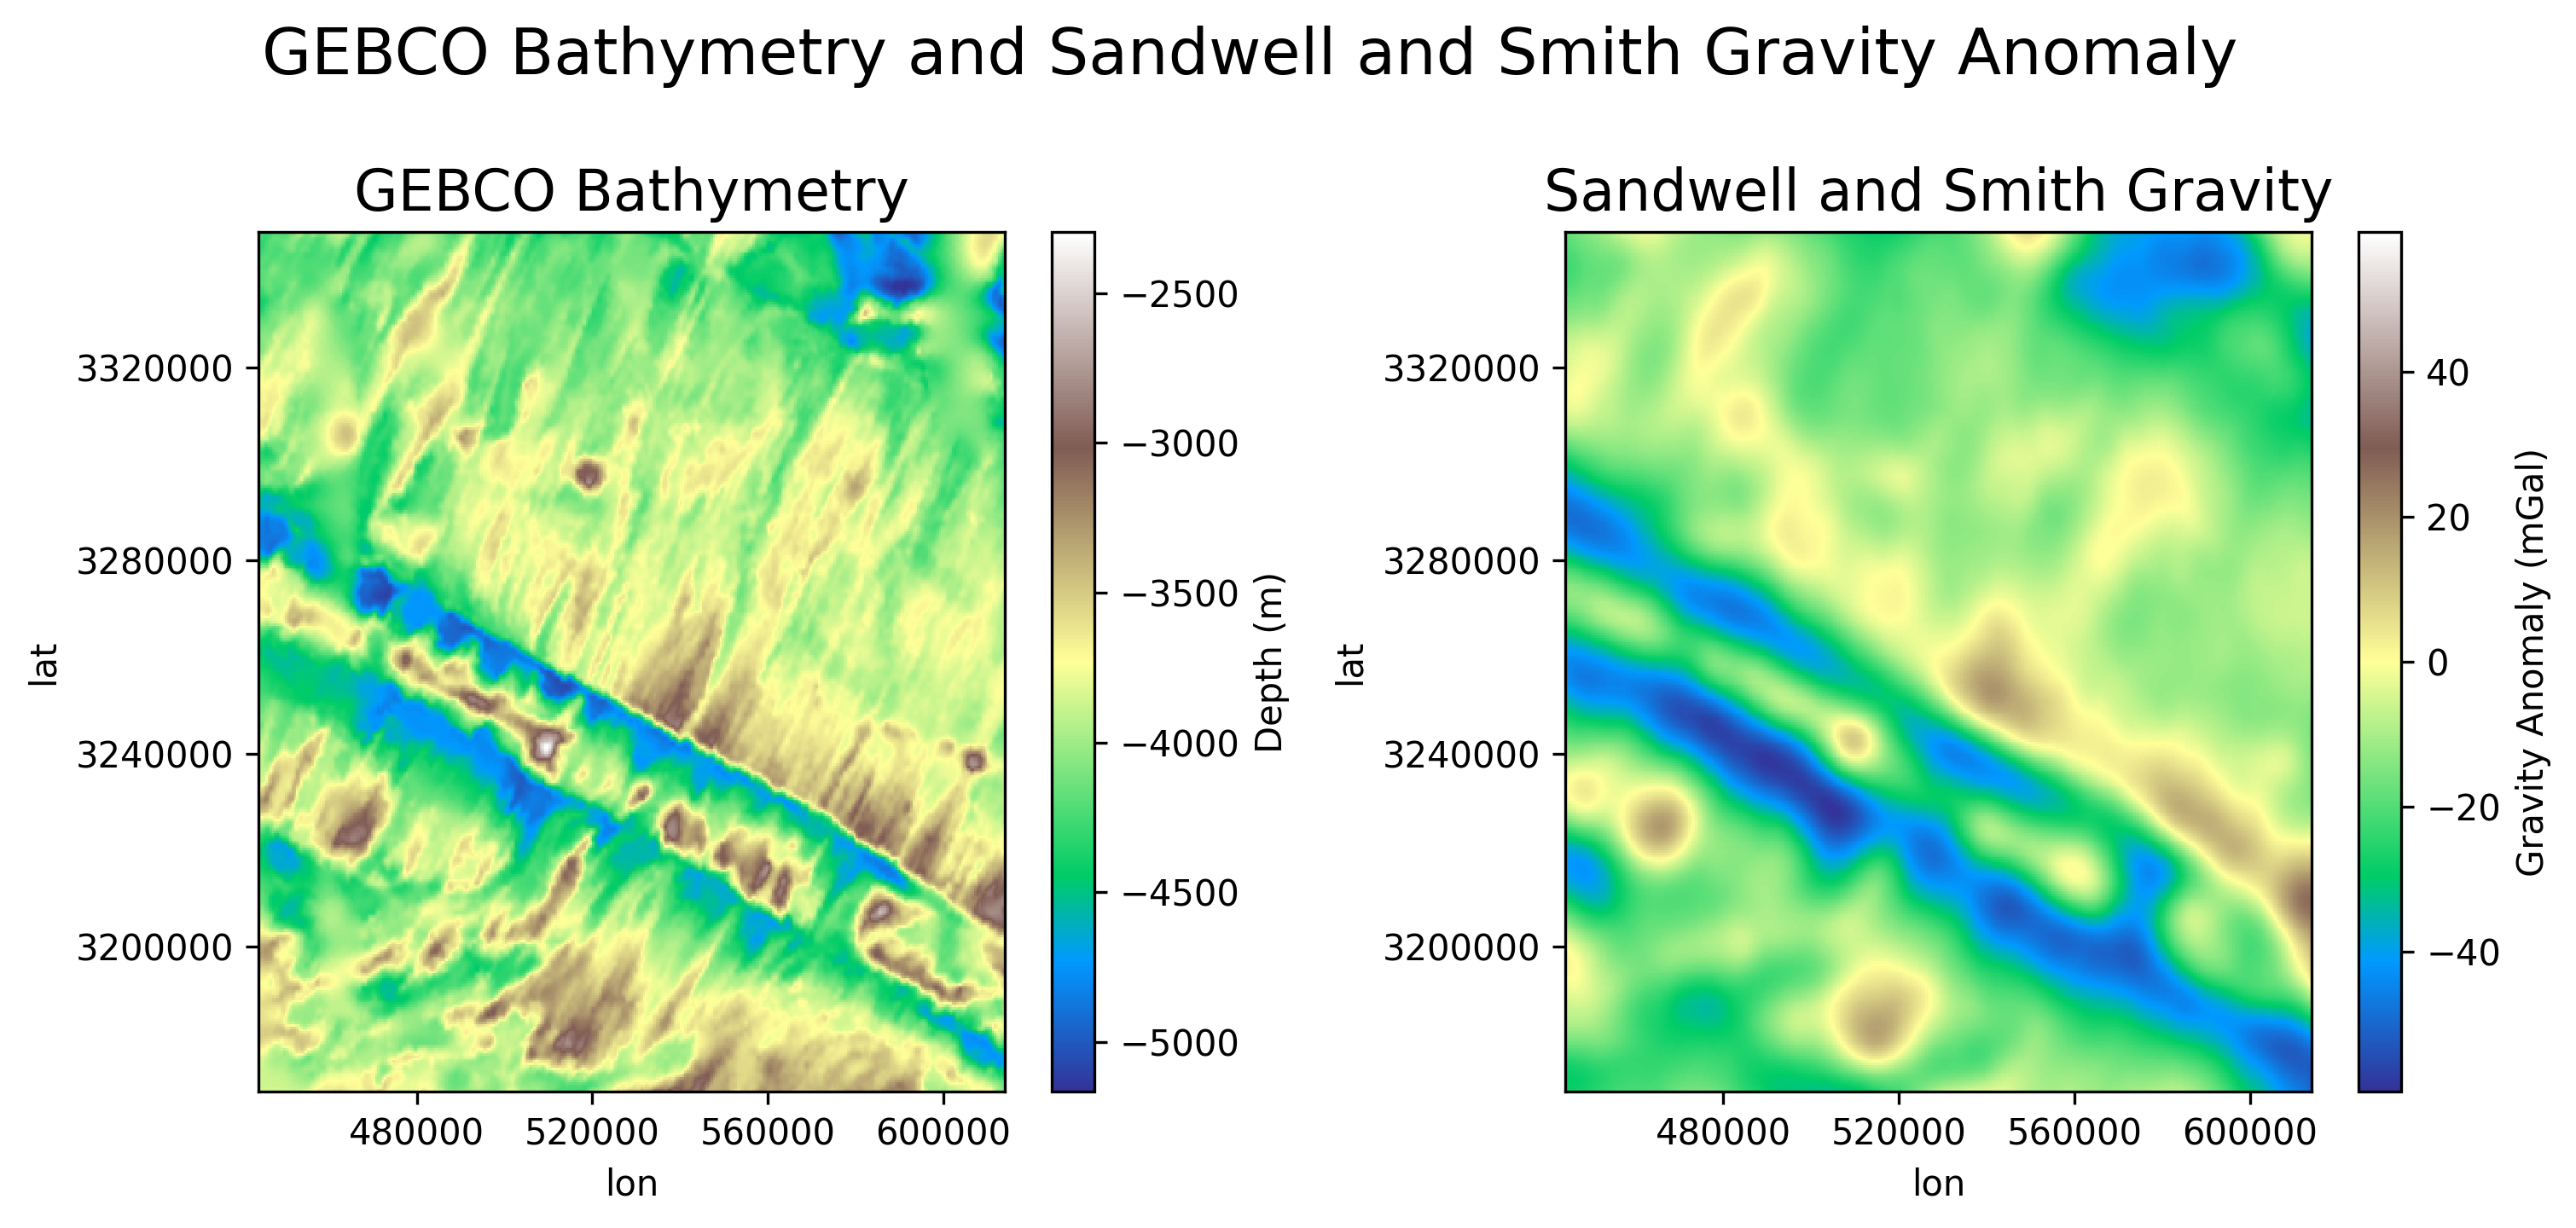

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10.5, 5), dpi=300)

# Plot GEBCO Bathymetry
dem_cbar = dem.plot(ax=ax1, cmap='terrain', add_colorbar=True, cbar_kwargs={'label': 'Depth (m)'})
ax1.set_title('GEBCO Bathymetry', fontsize=16)
ax1.xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
ax1.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
ax1.ticklabel_format(useOffset=False, style='plain', axis='y')

# Plot Sandwell and Smith Gravity
grv_cbar = grv.plot(ax=ax2, cmap='terrain', add_colorbar=True, cbar_kwargs={'label': 'Gravity Anomaly (mGal)'})
ax2.set_title('Sandwell and Smith Gravity', fontsize=16)
ax2.xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
ax2.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
ax2.ticklabel_format(useOffset=False, style='plain', axis='y')

fig.tight_layout(rect=[0.03, 0.03, 1, 0.9])
plt.suptitle('GEBCO Bathymetry and Sandwell and Smith Gravity Anomaly', fontsize=18)
plt.savefig('../data/processed/GEBCO and Sandwell and Smith Gravity Anomaly.jpg', dpi=300)
plt.show()

## Spectral Correlogram

In [18]:
da_grv_corr = geo3d.geo3d.correlogram(dem, grv, sigmas, 1)

Calculate spectrum: 100 wavelengths
....................................................................................................
Calculate spectrum: 100 wavelengths
....................................................................................................
Calculate correlogram: 100 wavelengths
....................................................................................................


In [19]:
float(da_grv_corr.min()),float(da_grv_corr.max())

(0.0, 0.96)

## Plot correlogram

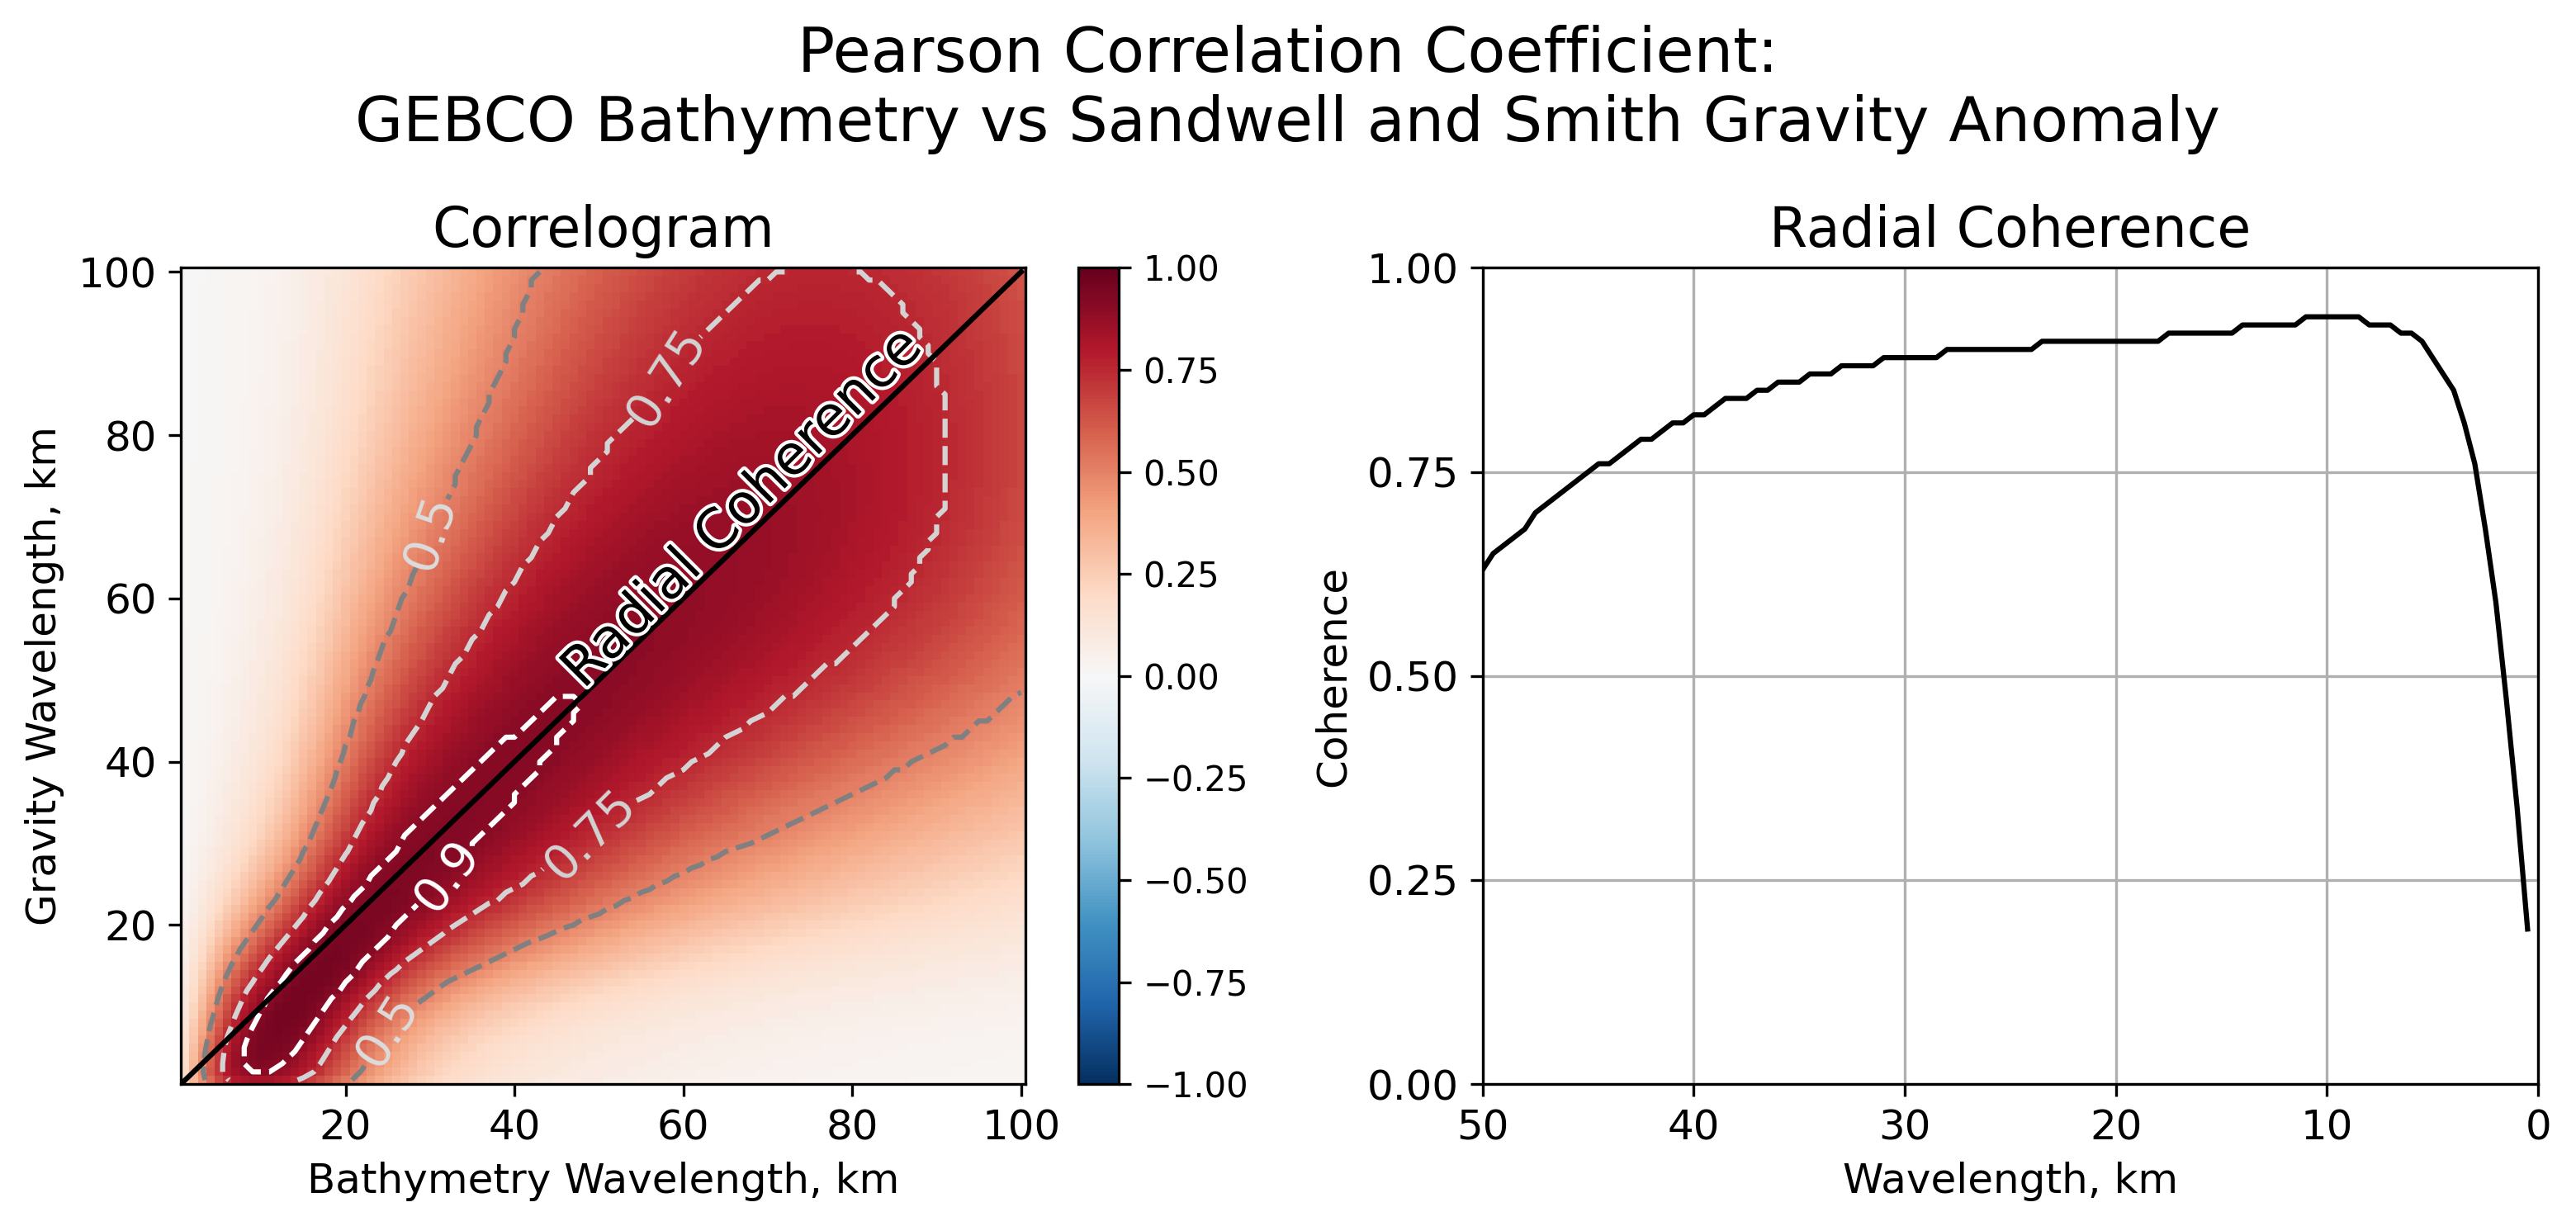

In [20]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10.5,5), dpi=300)

da_grv_corr.plot(cmap='RdBu_r',ax=ax1, vmin=-1,vmax=1)
contours = da_grv_corr.plot.contour(levels=[.5,.75, 0.9],colors=['gray','lightgray', 'white'],linestyles='--',ax=ax1)
ax1.clabel(contours, contours.levels, inline=True, fmt='%r', colors=['gainsboro','lightgray', 'white'], fontsize=14)
ax1.set_xlabel('Bathymetry Wavelength, km')
ax1.set_ylabel('Gravity Wavelength, km')
ax1.set_title('Correlogram')
ax1.plot([0, 100], [0, 100], color='black')
text = ax1.text(67, 71, 'Radial Coherence', color='black', rotation=45, ha='center', va='center', fontsize=16)
text.set_path_effects([patheffects.withStroke(linewidth=2, foreground='white')])

ax2.plot(resolution*sigmas, [float(da_grv_corr[g,g]) for g in range(len(sigmas))], c='black')
ax2.set_xlabel('Wavelength, km')
ax2.set_ylabel('Coherence')
ax2.set_yticks([0,0.25, 0.5, 0.75, 1])
ax2.yaxis.grid(True)
ax2.set_xlim([resolution*SIGMA,0])
ax2.set_title('Radial Coherence')
ax2.grid(True)

for ax in (ax1,ax2):
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.set_xlabel(ax.get_xlabel(), fontsize=12)
    ax.set_ylabel(ax.get_ylabel(), fontsize=12)
    ax.set_title(ax.get_title(), fontsize=16)

plt.suptitle('Pearson Correlation Coefficient:\nGEBCO Bathymetry vs Sandwell and Smith Gravity Anomaly', fontsize=18)
fig.tight_layout()
plt.savefig('../data/processed/Pearson Correlation Coefficient: GEBCO Bathymetry vs Sandwell and Smith Gravity Anomaly.jpg')
plt.show()

## Fractal Dimension Index

In [21]:
# note: correlogram calculation uses the same spectrums
dems = geo3d.geo3d.spectrum(dem, sigmas, 1)
grvs = geo3d.geo3d.spectrum(grv, sigmas, 1)

Calculate spectrum: 100 wavelengths
....................................................................................................
Calculate spectrum: 100 wavelengths
....................................................................................................


In [22]:
dem_stds = [_.std() for _ in dems]
grv_stds = [_.std() for _ in grvs]

In [23]:
slope = np.diff(np.log10(dem_stds))/np.diff(np.log10(resolution*sigmas))
dem_fractality = (3 - (slope/2))

slope = np.diff(np.log10(grv_stds))/np.diff(np.log10(resolution*sigmas))
grv_fractality = (3 - (slope/2))

In [24]:
# define real depth
depths = 0.707*resolution*(sigmas[1:] - DSIGMA/2)
depths_seafloor = -float(dem.mean())/1000+depths

## Density Model by Fractal Dimension Index

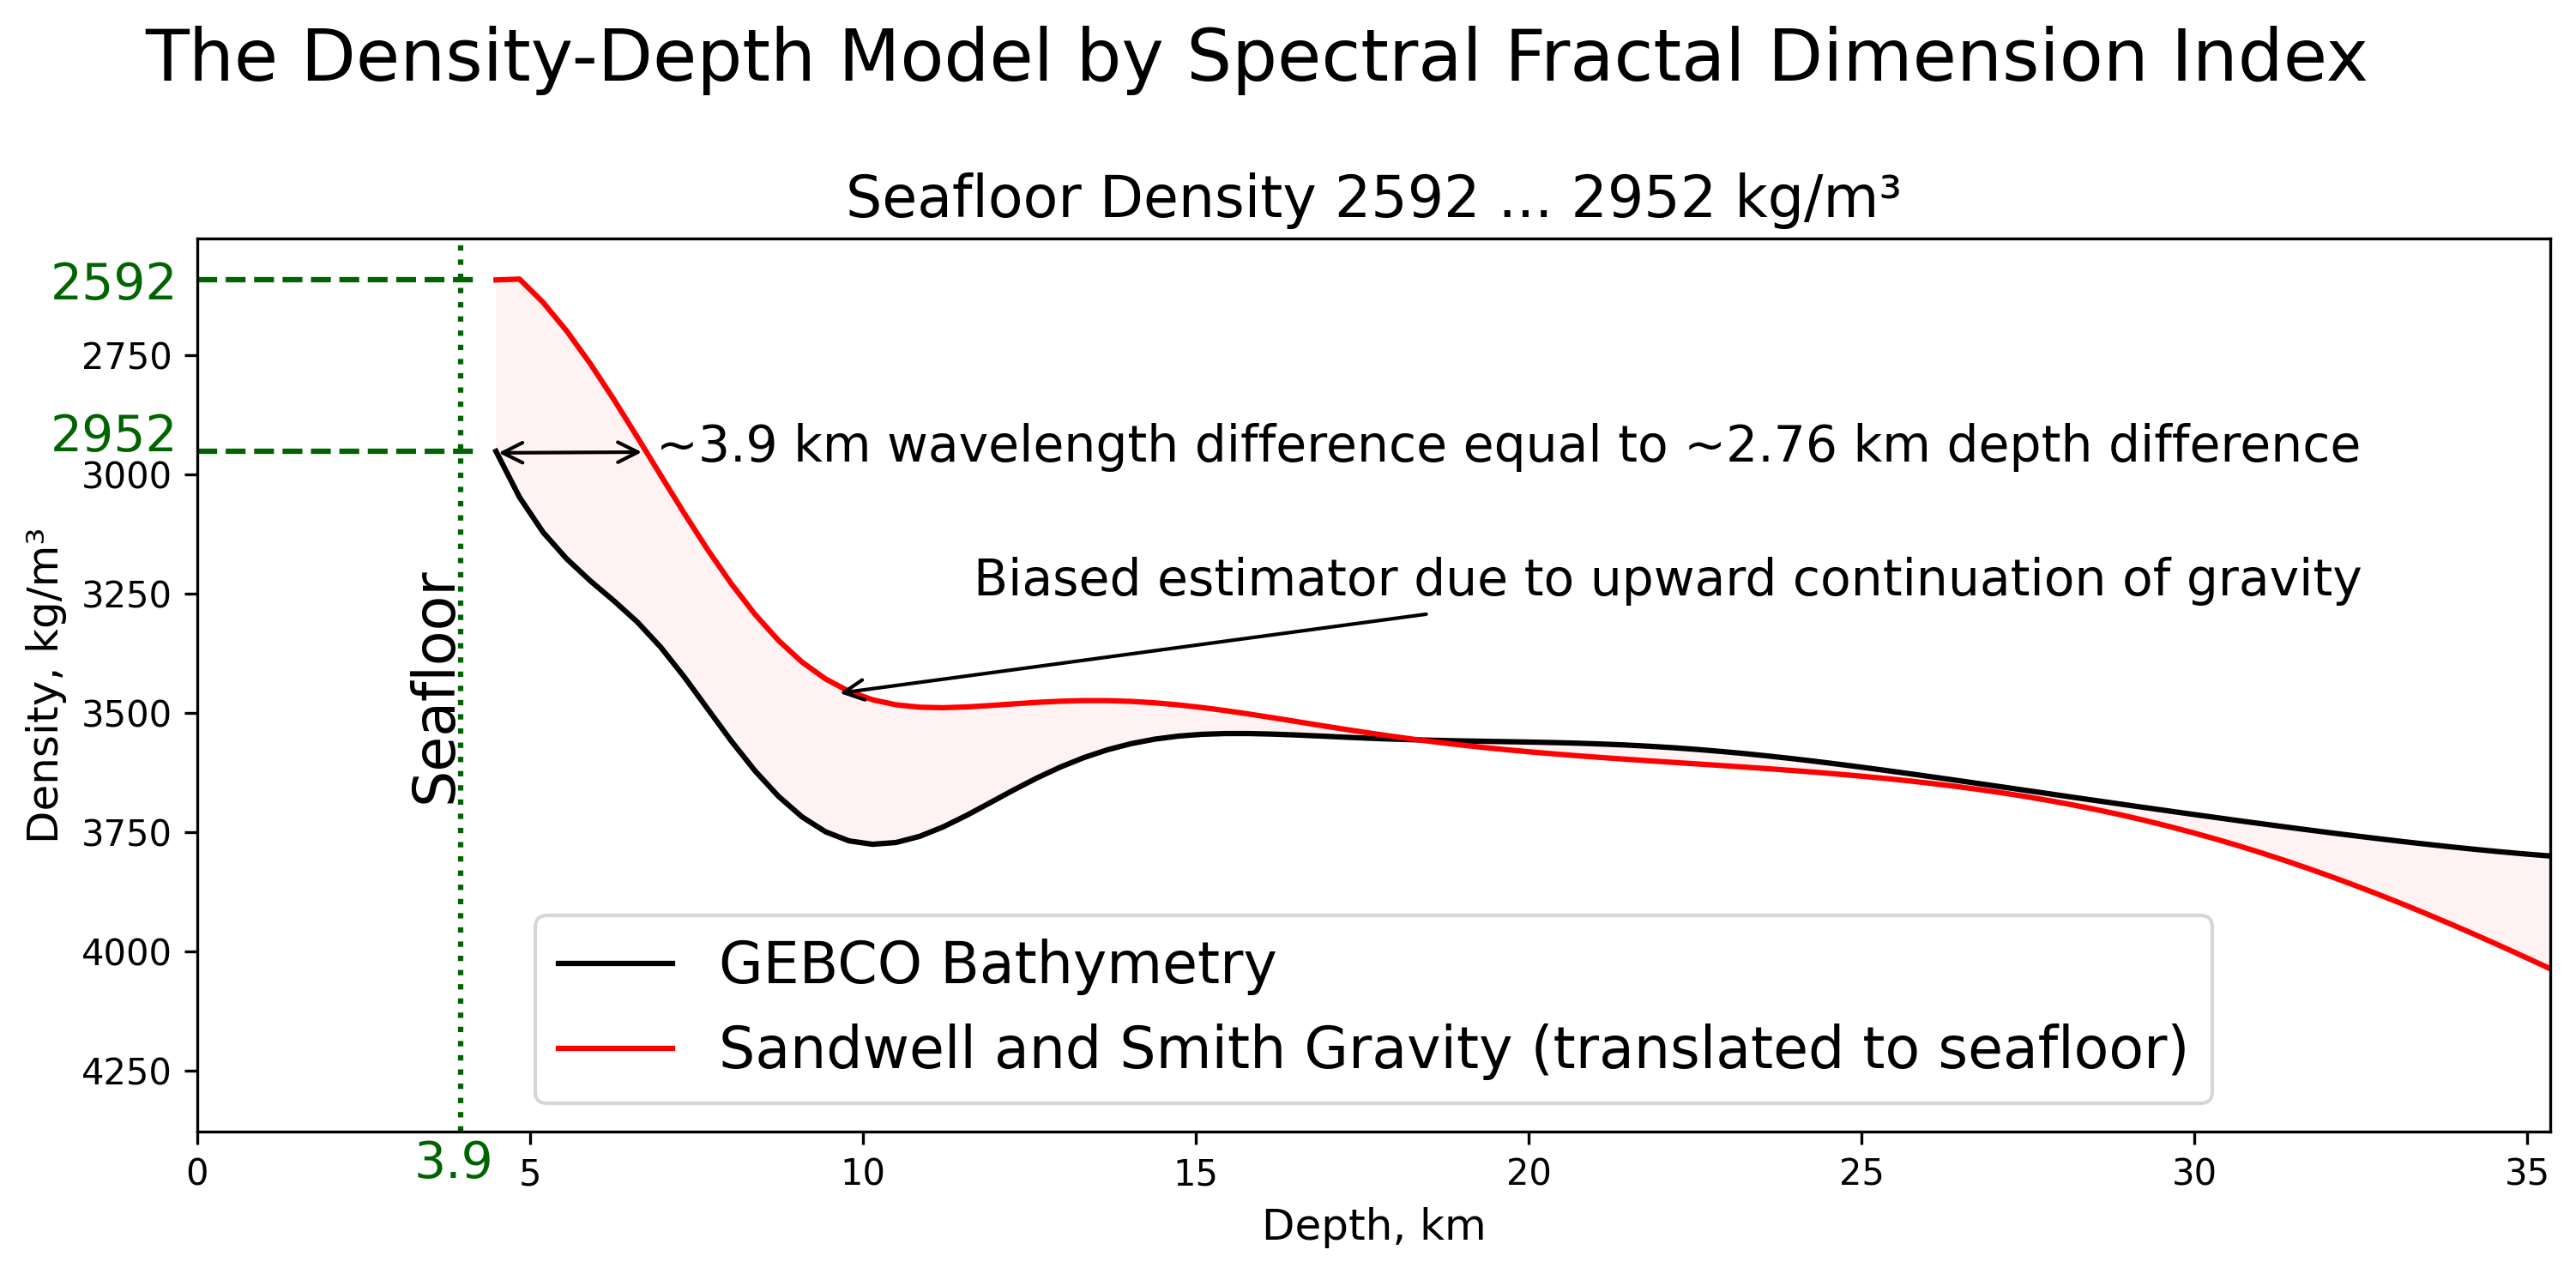

In [25]:
fig, ax = plt.subplots(1,1, figsize=(10.5,5), dpi=300)

ax.plot(depths_seafloor, 1000*dem_fractality, c='black', label='GEBCO Bathymetry')
#ax.plot(depths, 1000*grv_fractality, c='gray', linestyle=':',
#        label='Sandwell and Smith Gravity (biased estimator)')
ax.plot(depths_seafloor, 1000*grv_fractality, c='red',
        label='Sandwell and Smith Gravity (translated to seafloor)')
ax.set_xlim([0,0.707*resolution*SIGMA])
ax.legend(loc='lower center', fontsize=16)
ax.set_xlabel('Depth, km',fontsize=12)
ax.set_ylabel('Density, kg/m³',fontsize=12)
ax.invert_yaxis()
#ax.grid()

ax.axvline(x=-dem.mean()/1000, ymin=0, ymax=1, color = 'darkgreen', ls='dotted')
ax.text(-0.8-dem.mean()/1000, (ax.get_ylim()[0]+ax.get_ylim()[1])/2,
        "Seafloor", rotation=90, verticalalignment='center',fontsize=16)
ax.text(3.25, 4475, "3.9", color="darkgreen", fontsize=14)

ax.axhline(y=1000*grv_fractality[0], xmin=0, xmax=.12, color = 'darkgreen', ls='--')
ax.axhline(y=1000*dem_fractality[0], xmin=0, xmax=.12, color = 'darkgreen', ls='--')

ax.text(-2.2, 40+1000*grv_fractality[0], int(np.round(1000*grv_fractality[0])), color="darkgreen", fontsize=14)
ax.text(-2.2, 1000*dem_fractality[0], int(np.round(1000*dem_fractality[0])), color="darkgreen", fontsize=14)

ax.fill_between(depths_seafloor, 1000*dem_fractality, 1000*grv_fractality,
                facecolor='red', alpha=.05, interpolate=True)

ax.annotate("Biased estimator due to upward continuation of gravity",
            xy=(.27, 0.49), xytext=(.33, 0.6), xycoords='axes fraction',
             arrowprops=dict(arrowstyle="->"), fontsize=14)

ax.annotate("~3.9 km wavelength difference equal to ~2.76 km depth difference",
            xy=(.125, 0.76), xytext=(.195, 0.75), xycoords='axes fraction',
             arrowprops=dict(arrowstyle="<->"), fontsize=14)

plt.suptitle('The Density-Depth Model by Spectral Fractal Dimension Index',fontsize=20)
plt.title('Seafloor Density %d ... %d kg/m³' %
              (int(np.round(1000*grv_fractality[0])),int(np.round(1000*dem_fractality[0]))),fontsize=16)
fig.tight_layout(rect=[0.03, 0.0, 1, 0.98])
plt.savefig('../data/processed/Density Model by Fractal Dimension Index.jpg')
plt.show()